In [3]:
import os
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

In [4]:
# 1. Set dataset path and load
# Replace the path if your OS does not expand ~ correctly (use full path if needed).
DATA_PATH = os.path.expanduser('~/Downloads/fake_news/news_dataset.csv')

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please confirm the path.")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
display(df.head())

Loaded shape: (3729, 2)


,label,text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...
1,FAKE,A four-minute-long video of a woman criticisin...
2,FAKE,"Republic Poll, a fake Twitter account imitatin..."
3,REAL,"Delhi teen finds place on UN green list, turns..."
4,REAL,Delhi: A high-level meeting underway at reside...


In [5]:
# %%
text_col = None
label_col = None

for c in ['text','article','content','body','title','headline']:
    if c in df.columns:
        text_col = c
        break

for c in ['label','target','class','truth']:
    if c in df.columns:
        label_col = c
        break

if text_col is None or label_col is None:
    print("Auto-detection failed. Columns:", df.columns.tolist())
    raise ValueError("Please set `text_col` and `label_col` manually in the notebook.")

print("Using text_col =", text_col, "label_col =", label_col)
df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'})
display(df['label'].value_counts())


Using text_col = text label_col = label


FAKE    1877
REAL    1852
Name: label, dtype: int64

In [6]:
# %% [markdown]
# 3. Text cleaning / preprocessing helpers (robust to missing NLTK data)

# %%
import re
import nltk

# Try to load NLTK stopwords; if missing, try to download them.
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    print("NLTK stopwords not found — attempting to download...")
    try:
        nltk.download('stopwords', quiet=False)   # set quiet=True if you don't want output
        from nltk.corpus import stopwords
        STOPWORDS = set(stopwords.words('english'))
        print("NLTK stopwords downloaded and loaded.")
    except Exception as e:
        # Fallback minimal stopword set if download fails (offline environment / permissions)
        print("Could not download NLTK stopwords. Using fallback stopword list. Error:", e)
        STOPWORDS = {
            'a','an','the','and','or','is','are','was','were','in','on','at','of','for',
            'to','from','by','with','that','this','these','those','it','its','be','as',
            'have','has','had','i','you','he','she','they','we','my','your','their','our'
        }

print(f"Using {len(STOPWORDS)} stopwords.")

def clean_text(s: str) -> str:
    """
    Lowercase, remove URLs/HTML/punctuation, normalize whitespace, remove stopwords.
    Returns cleaned string.
    """
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)   # remove URLs
    s = re.sub(r"<.*?>", " ", s)                   # remove HTML tags
    s = re.sub(r"[^a-z0-9\s]", " ", s)             # remove punctuation (keep a-z0-9 and spaces)
    s = re.sub(r"\s+", " ", s).strip()             # normalize whitespace
    tokens = [w for w in s.split() if w not in STOPWORDS]
    return " ".join(tokens)

# quick test
print(clean_text("Breaking: NASA discovers water on Mars! Read more: https://example.com"))


Using 198 stopwords.
breaking nasa discovers water mars read


In [7]:
# 4. Apply cleaning; convert labels to numeric
# Expected label values: 'FAKE'/'REAL' or binary integers. Adjust mapping if your labels differ.

# %%
df['clean_text'] = df['text'].astype(str).apply(clean_text)

# map labels to numeric
if df['label'].dtype == object or not np.issubdtype(df['label'].dtype, np.number):
    unique = df['label'].unique().tolist()
    print("Unique labels detected:", unique)
    if set(['FAKE','REAL']).issubset(set(unique)):
        mapping = {'FAKE': 1, 'REAL': 0}
    else:
        # fallback: first unique -> 0, others -> 1
        mapping = {unique[0]: 0}
        for u in unique[1:]:
            mapping[u] = 1
    df['label_num'] = df['label'].map(mapping)
else:
    df['label_num'] = df['label'].astype(int)

# drop missing
df = df.dropna(subset=['clean_text', 'label_num'])
print("After cleaning shape:", df.shape)
display(df.head())


Unique labels detected: ['REAL', 'FAKE']
After cleaning shape: (3729, 4)


,text,label,clean_text,label_num
0,Payal has accused filmmaker Anurag Kashyap of ...,REAL,payal accused filmmaker anurag kashyap behavin...,0
1,A four-minute-long video of a woman criticisin...,FAKE,four minute long video woman criticising gover...,1
2,"Republic Poll, a fake Twitter account imitatin...",FAKE,republic poll fake twitter account imitating a...,1
3,"Delhi teen finds place on UN green list, turns...",REAL,delhi teen finds place un green list turns gla...,0
4,Delhi: A high-level meeting underway at reside...,REAL,delhi high level meeting underway residence ra...,0


In [8]:
# 5. Train / test split (stratified)
# Use stratify to keep class balance.

# %%
X = df['clean_text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", len(X_train), "Test:", len(X_test))

Train: 2983 Test: 746


In [9]:
# 6. Baseline pipeline: TF-IDF + Logistic Regression

# %%
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
preds_lr = pipe_lr.predict(X_test)

print("Logistic Regression performance")
print("Accuracy:", accuracy_score(y_test, preds_lr))
print("Precision:", precision_score(y_test, preds_lr))
print("Recall:", recall_score(y_test, preds_lr))
print("F1:", f1_score(y_test, preds_lr))
print("\nClassification report:\n", classification_report(y_test, preds_lr))

Logistic Regression performance
Accuracy: 0.9959785522788204
Precision: 0.9973333333333333
Recall: 0.9946808510638298
F1: 0.9960053262316911

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       370
           1       1.00      0.99      1.00       376

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746



In [10]:
# 7. Alternative model: TF-IDF + Random Forest (comparison)

# %%
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_rf.fit(X_train, y_train)
preds_rf = pipe_rf.predict(X_test)

print("Random Forest performance")
print("Accuracy:", accuracy_score(y_test, preds_rf))
print("F1:", f1_score(y_test, preds_rf))

Random Forest performance
Accuracy: 0.9986595174262735
F1: 0.99867197875166


In [11]:
# 8. Optional: GridSearch for Logistic Regression hyperparameters
# This may take time depending on dataset size.

# %%
param_grid = {
    'tfidf__max_df': [0.75, 0.85, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1.0, 10.0]
}

grid = GridSearchCV(pipe_lr, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

preds_best = best_model.predict(X_test)
print("Grid best model F1:", f1_score(y_test, preds_best))
print(classification_report(y_test, preds_best))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'clf__C': 10.0, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 1)}
Grid best model F1: 0.9960053262316911
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       370
           1       1.00      0.99      1.00       376

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746



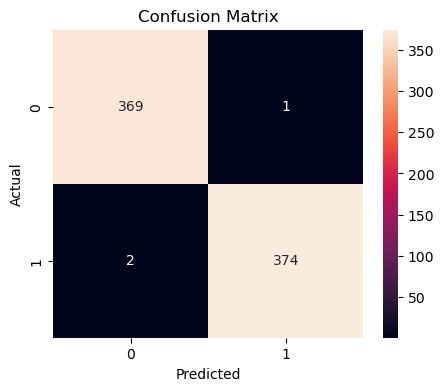

In [ ]:
# 9. Confusion matrix visualization

# %%
import seaborn as sns
cm = confusion_matrix(y_test, preds_best if 'preds_best' in locals() else preds_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# 10. Save/Load model and sample inference

# %%
MODEL_DIR = os.path.expanduser('~/Downloads/fake_news/models')
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, 'fake_news_model.joblib')

model_to_save = best_model if 'best_model' in locals() else pipe_lr
joblib.dump(model_to_save, MODEL_PATH)
print("Saved model to", MODEL_PATH)

# Load and test
loaded = joblib.load(MODEL_PATH)
samples = [
    "Breaking: Scientists discover cure for common cold",
    "Celebrity was seen stealing millions from charity, sources say"
]
samples_clean = [clean_text(s) for s in samples]
preds_samples = loaded.predict(samples_clean)
try:
    probs = loaded.predict_proba(samples_clean)
except Exception:
    probs = None

for i, s in enumerate(samples):
    print("\nTEXT:", s)
    print("PRED:", preds_samples[i])
    if probs is not None:
        print("PROB:", probs[i])


Saved model to C:\Users\moham/Downloads/fake_news/models\fake_news_model.joblib

TEXT: Breaking: Scientists discover cure for common cold
PRED: 0
PROB: [0.61295118 0.38704882]

TEXT: Celebrity was seen stealing millions from charity, sources say
PRED: 0
PROB: [0.69303101 0.30696899]


In [5]:
# %% [markdown]
# Single-run prediction: enter one statement, get one prediction (run cell again for another)

# %%
import os
import joblib
import re

MODEL_PATH = os.path.expanduser('~/Downloads/fake_news/models/fake_news_model.joblib')

# ---- Ensure clean_text exists (if not, provide a minimal fallback) ----
if 'clean_text' not in globals():
    print("Warning: 'clean_text' not found in current session. Defining a minimal fallback cleaner.")
    # Minimal stopword list
    _STOPWORDS = {
        'a','an','the','and','or','is','are','was','were','in','on','at','of','for','to','from','by','with',
        'that','this','it','its','be','as','have','has','had','i','you','he','she','they','we','my','your'
    }
    def clean_text(s: str) -> str:
        if not isinstance(s, str):
            return ""
        s = s.lower()
        s = re.sub(r"https?://\S+|www\.\S+", " ", s)
        s = re.sub(r"<.*?>", " ", s)
        s = re.sub(r"[^a-z0-9\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = [w for w in s.split() if w not in _STOPWORDS]
        return " ".join(tokens)

# ---- Try to load model from disk; if not present, try in-memory variables ----
model = None
if os.path.exists(MODEL_PATH):
    try:
        model = joblib.load(MODEL_PATH)
        print(f"✅ Loaded model from: {MODEL_PATH}")
    except Exception as e:
        print(f"⚠️ Failed to load model from {MODEL_PATH}: {e}")

# fallback: common in-memory names from notebook
if model is None:
    for cand in ['best', 'best_model', 'model_to_save', 'pipe_lr', 'pipe_rf', 'grid', 'grid_search']:
        if cand in globals():
            model = globals()[cand]
            print(f"✅ Using in-memory model named '{cand}'.")
            break

if model is None:
    raise RuntimeError("❌ No trained model found. Make sure you've trained a model or saved it to "
                       f"'{MODEL_PATH}' and rerun the training cells before running this prediction cell.")

# ---- Prediction function ----
def predict_one(statement: str):
    if not isinstance(statement, str) or statement.strip() == "":
        print("⚠️ Empty input — please enter a non-empty statement.")
        return
    cleaned = clean_text(statement)
    try:
        pred = model.predict([cleaned])[0]
    except Exception as e:
        print("❌ Model prediction failed:", e)
        return

    # Map numeric prediction to labels (common mapping used elsewhere: 1 -> FAKE, 0 -> REAL)
    try:
        label = "FAKE" if int(pred) == 1 else "REAL"
    except Exception:
        label = str(pred)

    # Try probability if available
    proba_str = ""
    try:
        probs = model.predict_proba([cleaned])[0]
        # If binary classification, show probability for predicted class
        conf = probs[int(pred)] if len(probs) > int(pred) else max(probs)
        proba_str = f" (confidence: {conf:.2f})"
    except Exception:
        proba_str = ""

    print("\n📰 Input:", statement)
    print("📊 Prediction:", label + proba_str)

# ---- Single-run interactive input ----
user_text = input("\nEnter a news statement to predict (press Enter to submit): ").strip()
if not user_text:
    print("⚠️ No input entered. Rerun this cell and type a statement to predict.")
else:
    predict_one(user_text)


✅ Loaded model from: C:\Users\moham/Downloads/fake_news/models/fake_news_model.joblib

📰 Input: Muslim Politician Disguised As A Hindu In Anti-CAA Protests?
📊 Prediction: FAKE (confidence: 0.70)
